In this notebook, we will show how to load pre-trained models and draw things with sketch-rnn

In [1]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
import csv

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [2]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


INFO:tensorflow:TensorFlow Version: 1.4.0


In [3]:
# import our command line tools
import sys
sys.path.insert(0, './sketch_rnn/test')
from sketch_rnn_train import *
from model import *
from utils import *
from rnn import *

In [4]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [5]:
# data_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/sketchy_data/'
# data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
data_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/sketchy_data/'
models_root_dir = '/tmp/sketch_rnn/models'
# model_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/airplane_c1_1'
# model_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/data5'
# model_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/layer_norm_1000/trained_data10'
# model_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/lstm_1000/trained_data2'
model_dir = '/tmp/sketch_rnn/models/owl/lstm_test/'
# model_dir = '/tmp/sketch_rnn/models/aaron_sheep/layer_norm/'
# model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [6]:
download_pretrained_models(models_root_dir=models_root_dir)

INFO:tensorflow:/tmp/sketch_rnn/models/sketch_rnn.zip already exists, using cached copy
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


In [7]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)
# [hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)

INFO:tensorflow:Loaded 100/100/100 from owl174s_ep3_tt.npz
INFO:tensorflow:Dataset combined: 300 (100/100/100), avg len 104
INFO:tensorflow:model_params.max_seq_len 174.
total images <= max_seq_len is 100
total images <= max_seq_len is 100
total images <= max_seq_len is 100
INFO:tensorflow:normalizing_scale_factor 80.4230.


In [8]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/owl/lstm_test/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/owl/lstm_test/vector


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [11]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes, max_len=168).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  print("in encode(): seq_len = {}".format(seq_len))
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [12]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

100
(146, 3)


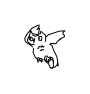

In [13]:
# get a sample drawing from the test set, and render it to .svg
# stroke = test_set.random_sample()
print len(train_set.strokes)
# stroke = train_set.random_sample()
lat_vec = []
stroke = train_set.strokes[0]
print(stroke.shape)
draw_strokes(stroke)

Let's try to encode the sample stroke into latent vector $z$

in encode(): seq_len = [146]


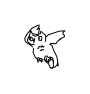

ValueError: Cannot feed value of shape (1, 169, 5) for Tensor u'vector_rnn_1/Placeholder_1:0', which has shape '(1, 175, 5)'

In [14]:
z = encode(stroke) #definition of latent vector z
# for i in range(len(train_set.strokes)):
#     lat_vec.append(encode(train_set.strokes[i]))
# with open("owl_z_tt.csv","w+") as _csv:
#     csvw = csv.writer(_csv,delimiter=',')
#     csvw.writerows(lat_vec)

print len(lat_vec[0])

In [ ]:
_ = decode(z, temperature=0.1) # convert z back to drawing at temperature of 0.1

Create generated grid at various temperatures from 0.1 to 1.0

In [ ]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Latent Space Interpolation Example between $z_0$ and $z_1$

In [ ]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

In [ ]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [ ]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [ ]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation

In [15]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm_test/'
# sketchy_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/sketchy_data/' #sheep_ep03.npz
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)

INFO:tensorflow:Loaded 100/100/100 from elephant_ep3.npz
INFO:tensorflow:Dataset combined: 300 (100/100/100), avg len 108
INFO:tensorflow:model_params.max_seq_len 168.
total images <= max_seq_len is 100
total images <= max_seq_len is 100
total images <= max_seq_len is 100
INFO:tensorflow:normalizing_scale_factor 84.4286.


In [16]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)

In [17]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [18]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [19]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/elephantpig/lstm_test/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/elephantpig/lstm_test/vector


in encode(): seq_len = [72]


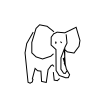

in encode(): seq_len = [82]


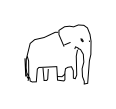

in encode(): seq_len = [81]


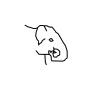

in encode(): seq_len = [107]


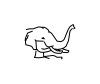

in encode(): seq_len = [100]


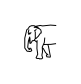

in encode(): seq_len = [86]


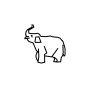

in encode(): seq_len = [119]


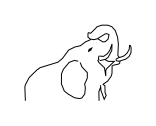

in encode(): seq_len = [114]


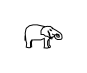

in encode(): seq_len = [168]


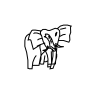

in encode(): seq_len = [113]


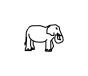

in encode(): seq_len = [101]


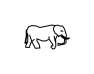

in encode(): seq_len = [157]


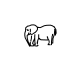

in encode(): seq_len = [126]


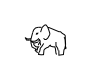

in encode(): seq_len = [83]


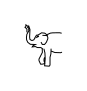

in encode(): seq_len = [122]


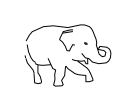

in encode(): seq_len = [104]


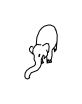

in encode(): seq_len = [121]


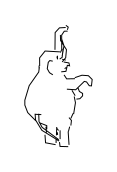

in encode(): seq_len = [54]


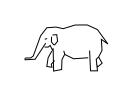

in encode(): seq_len = [168]


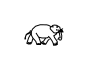

in encode(): seq_len = [62]


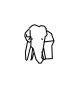

in encode(): seq_len = [125]


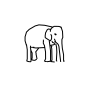

in encode(): seq_len = [168]


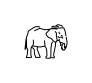

in encode(): seq_len = [78]


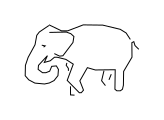

in encode(): seq_len = [77]


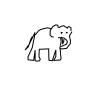

in encode(): seq_len = [91]


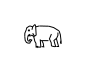

in encode(): seq_len = [168]


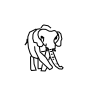

in encode(): seq_len = [105]


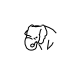

in encode(): seq_len = [116]


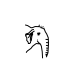

in encode(): seq_len = [121]


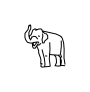

in encode(): seq_len = [99]


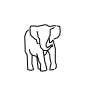

in encode(): seq_len = [88]


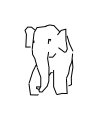

in encode(): seq_len = [113]


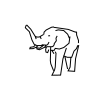

in encode(): seq_len = [100]


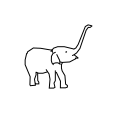

in encode(): seq_len = [121]


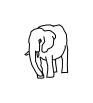

in encode(): seq_len = [76]


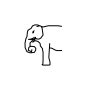

in encode(): seq_len = [93]


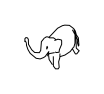

in encode(): seq_len = [122]


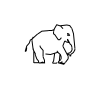

in encode(): seq_len = [93]


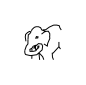

in encode(): seq_len = [104]


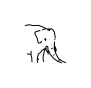

in encode(): seq_len = [76]


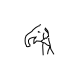

in encode(): seq_len = [84]


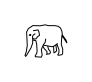

in encode(): seq_len = [143]


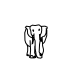

in encode(): seq_len = [148]


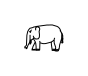

in encode(): seq_len = [115]


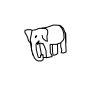

in encode(): seq_len = [96]


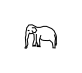

in encode(): seq_len = [92]


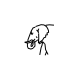

in encode(): seq_len = [117]


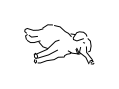

in encode(): seq_len = [96]


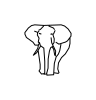

in encode(): seq_len = [73]


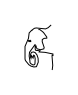

in encode(): seq_len = [74]


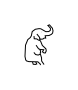

in encode(): seq_len = [81]


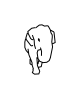

in encode(): seq_len = [69]


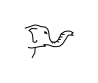

in encode(): seq_len = [140]


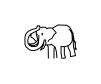

in encode(): seq_len = [114]


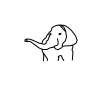

in encode(): seq_len = [99]


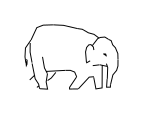

in encode(): seq_len = [166]


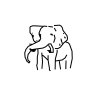

in encode(): seq_len = [99]


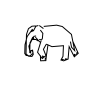

in encode(): seq_len = [157]


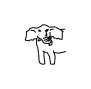

in encode(): seq_len = [168]


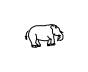

in encode(): seq_len = [108]


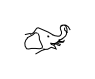

in encode(): seq_len = [117]


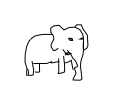

in encode(): seq_len = [90]


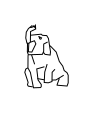

in encode(): seq_len = [94]


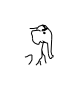

in encode(): seq_len = [114]


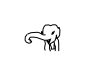

in encode(): seq_len = [100]


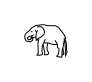

in encode(): seq_len = [96]


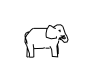

in encode(): seq_len = [157]


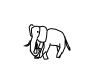

in encode(): seq_len = [89]


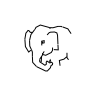

in encode(): seq_len = [109]


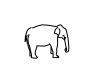

in encode(): seq_len = [93]


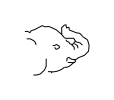

in encode(): seq_len = [95]


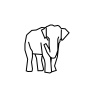

in encode(): seq_len = [51]


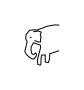

in encode(): seq_len = [122]


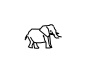

in encode(): seq_len = [107]


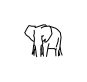

in encode(): seq_len = [62]


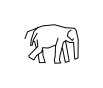

in encode(): seq_len = [126]


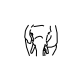

in encode(): seq_len = [111]


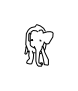

in encode(): seq_len = [121]


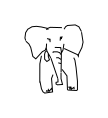

in encode(): seq_len = [79]


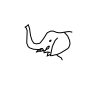

in encode(): seq_len = [90]


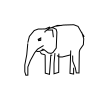

in encode(): seq_len = [104]


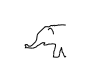

in encode(): seq_len = [67]


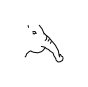

in encode(): seq_len = [98]


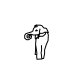

in encode(): seq_len = [168]


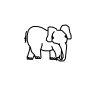

in encode(): seq_len = [65]


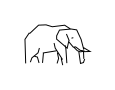

in encode(): seq_len = [168]


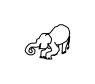

in encode(): seq_len = [151]


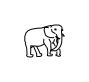

in encode(): seq_len = [105]


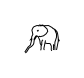

in encode(): seq_len = [103]


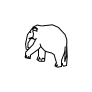

in encode(): seq_len = [101]


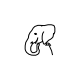

in encode(): seq_len = [121]


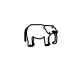

in encode(): seq_len = [102]


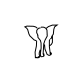

in encode(): seq_len = [123]


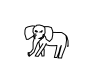

in encode(): seq_len = [168]


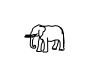

in encode(): seq_len = [116]


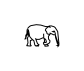

in encode(): seq_len = [103]


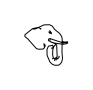

in encode(): seq_len = [118]


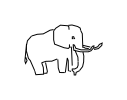

in encode(): seq_len = [112]


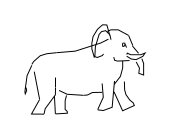

in encode(): seq_len = [140]


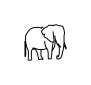

in encode(): seq_len = [107]


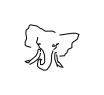

In [20]:
# encode strokes
for i in range(len(train_set.strokes)):
    lat_vec.append(encode(train_set.strokes[i]))
with open("elephant_z_tt.csv","w+") as _csv:
    csvw = csv.writer(_csv,delimiter=',')
    csvw.writerows(lat_vec)

In [21]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])

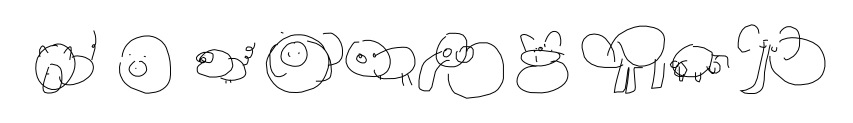

In [22]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)